# Clasificación de Cáncer de Mama

Este notebook representa un flujo de trabajo "Golden Standard" para proyectos de clasificación binaria. 
El objetivo es no solo entrenar modelos, sino entender profundamente los datos y el comportamiento de los algoritmos mediante diagnósticos avanzados.

## A. Configuración y Filosofía
Comenzamos configurando el entorno, asegurando la reproducibilidad y definiendo nuestra filosofía estética.

In [11]:
import sys
import os

# Agregar src a la ruta para permitir importar módulos locales
current_dir = os.getcwd()
if os.path.isdir(os.path.join(current_dir, 'src')):
    sys.path.append(os.path.abspath(os.path.join(current_dir, 'src')))
elif os.path.isdir(os.path.join(current_dir, '..', 'src')):
    sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importar módulos personalizados
from visualization import set_style, plot_distributions, plot_correlation_heatmap, plot_model_comparison, plot_selected_pairplot, plot_learning_curves
from data_loader import load_data, get_feature_target_split
from processing import split_data
from modeling import get_models, train_and_evaluate

# Establecer semilla aleatoria para reproducibilidad global
np.random.seed(42)

# Aplicar estilo estético personalizado
set_style()

## B. Carga e Inspección de Datos
Cargamos el conjunto de datos y realizamos una inspección estadística inicial para detectar anomalías, valores nulos o escalas dispares.

In [12]:
df = load_data()
print(f"Forma del Dataset: {df.shape}")
df.head()

Forma del Dataset: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Inspección Estadística
Usamos `info()` para verificar tipos de datos y nulos, y `describe()` para entender la magnitud de las características.

**Qué buscar:**
*   **Nulos:** ¿Faltan datos que debamos imputar?
*   **Escalas:** Observa `mean` y `std`. Si una característica tiene una media de 0.05 y otra de 1000, ¡necesitamos escalar los datos! (Esto justifica el uso de `StandardScaler` más adelante).

In [13]:
print("--- Información del DataFrame ---")
df.info()

print("\n--- Estadísticas Descriptivas ---")
df.describe().T

--- Información del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


## C. Análisis Exploratorio de Datos (EDA) Estilizado
Entender la distribución de los datos y las relaciones es crucial. Usamos visualizaciones personalizadas para inspeccionar las características.

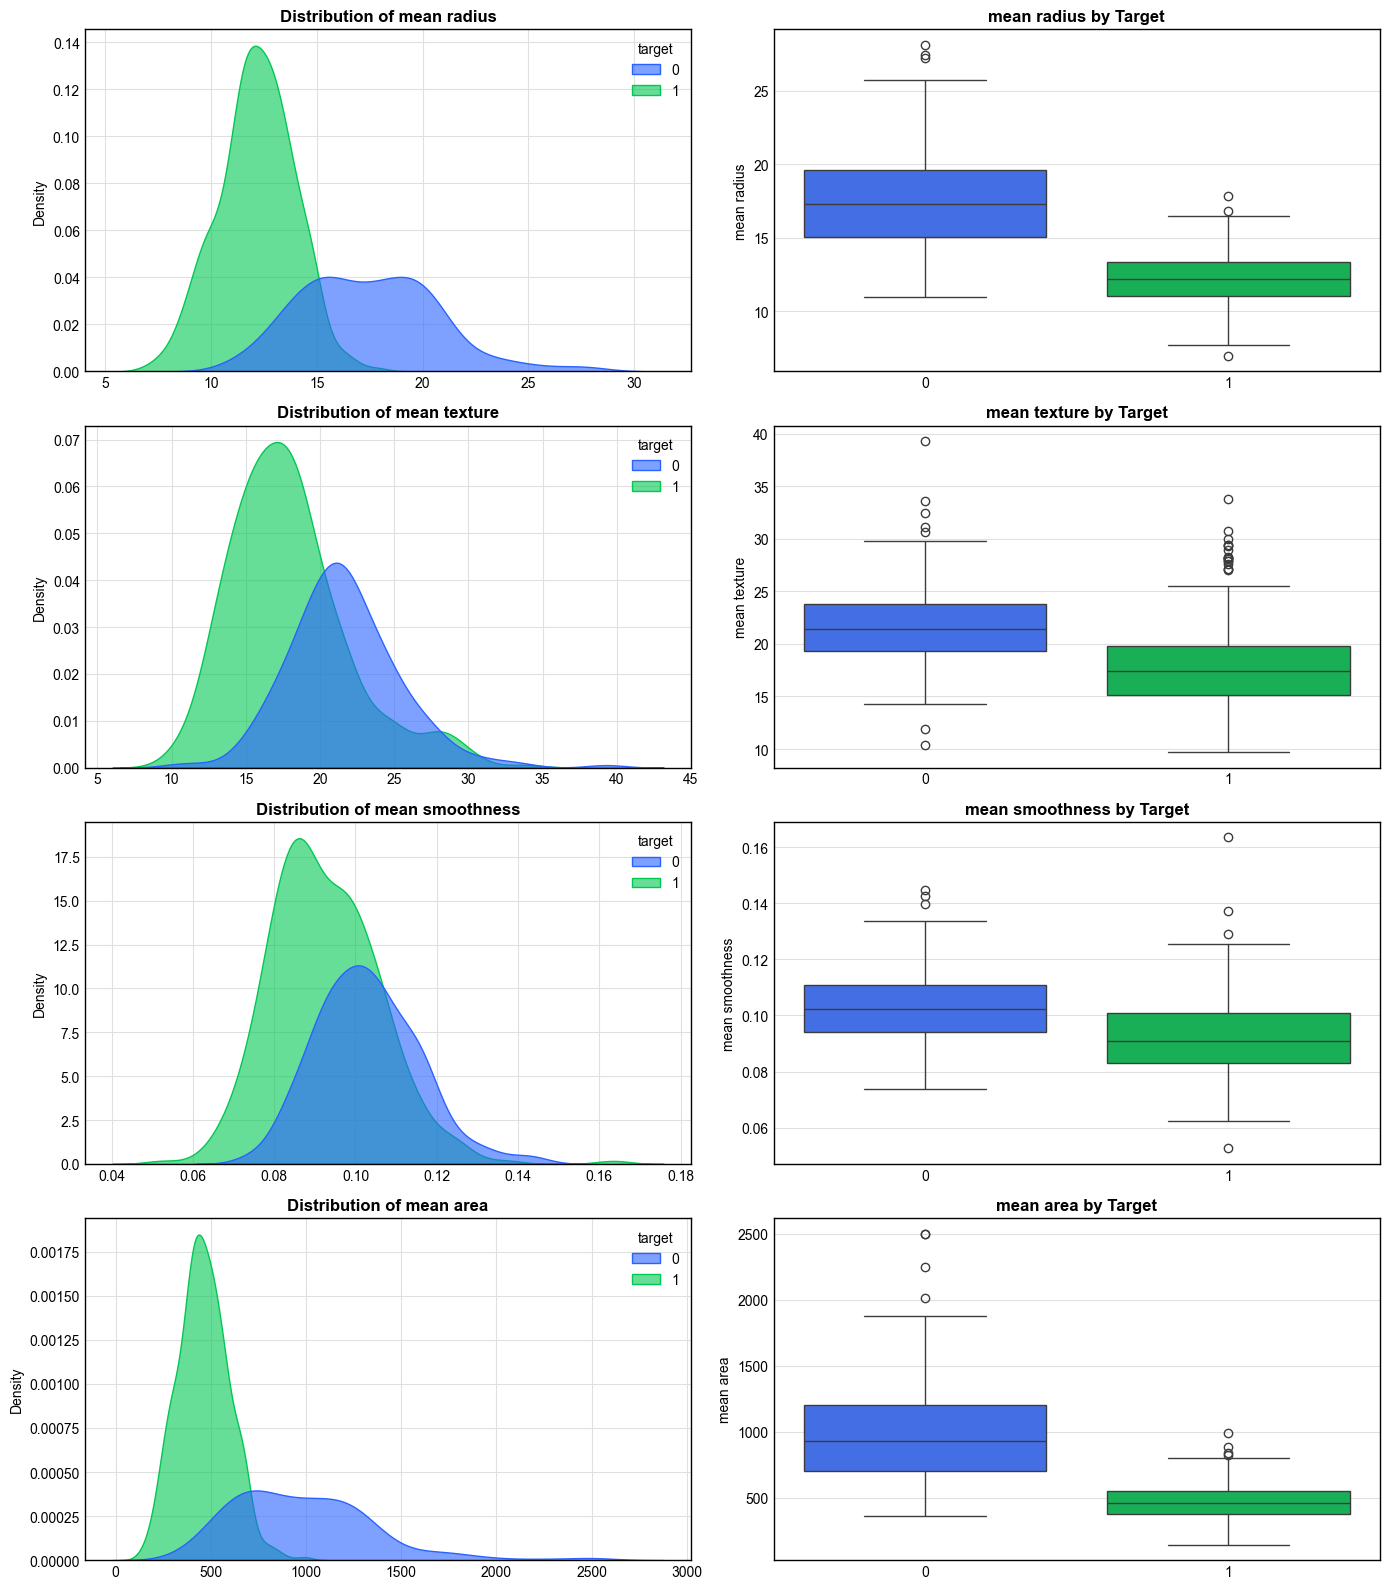

In [14]:
# Analizar distribución de características clave
target_col = 'target'
features_to_plot = ['mean radius', 'mean texture', 'mean smoothness', 'mean area']

plot_distributions(df, features_to_plot, target_col)

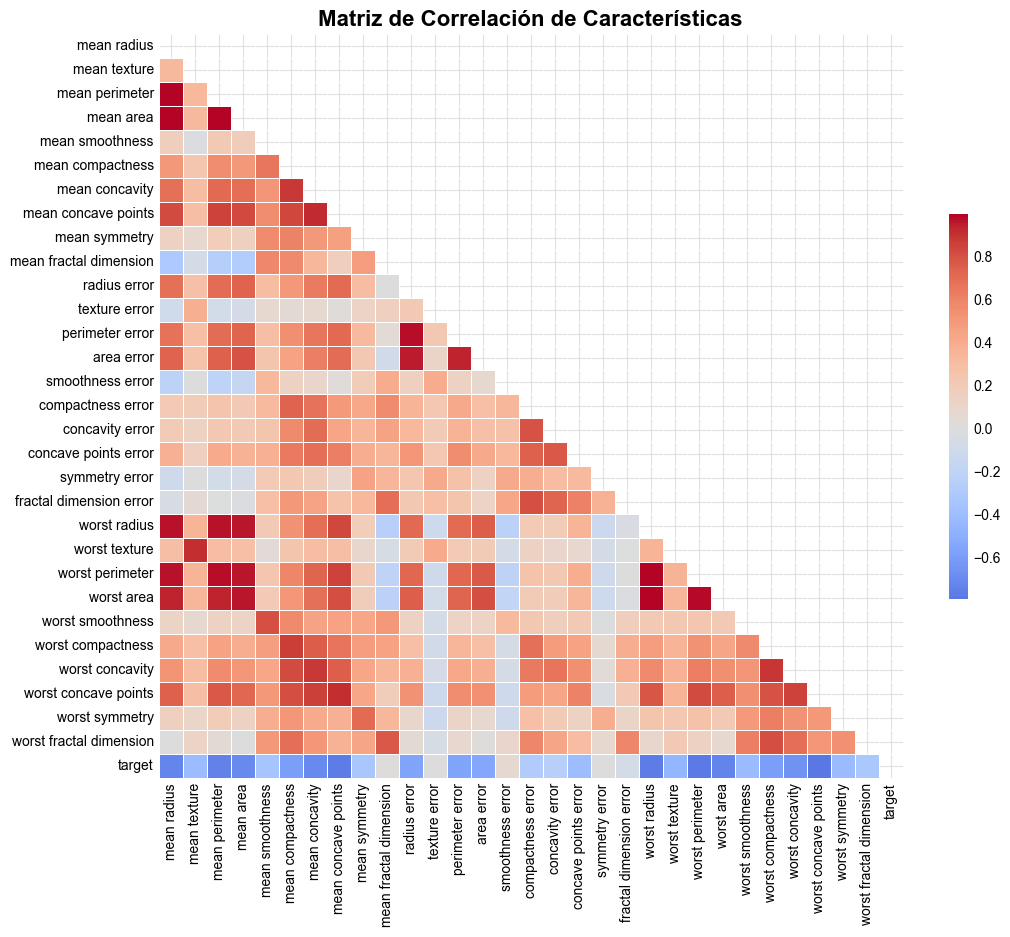

In [15]:
# Analizar correlaciones
plot_correlation_heatmap(df)

### Análisis de Separabilidad (Pairplot)
Seleccionamos las características con mayor correlación (según el mapa de calor anterior) para ver si las clases son linealmente separables.

**Interpretación:** Si vemos grupos claros y separados por color, modelos lineales como Regresión Logística funcionarán muy bien.

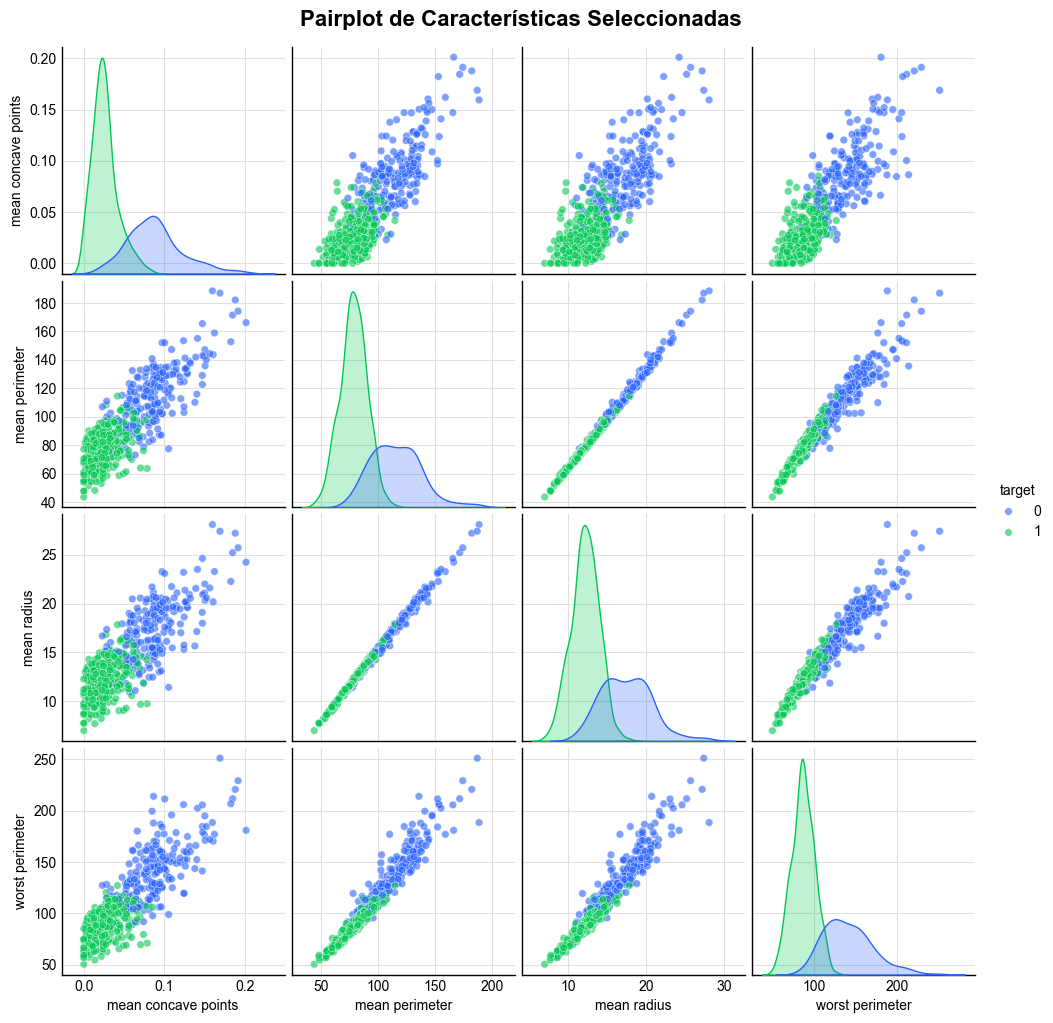

In [16]:
# Seleccionamos características altamente correlacionadas o de interés
top_features = ['mean concave points', 'mean perimeter', 'mean radius', 'worst perimeter']
plot_selected_pairplot(df, top_features, target_col)

## D. Preprocesamiento y División
Dividimos los datos en conjuntos de entrenamiento y prueba. 

**¿Por qué estratificar?** 
Usamos muestreo estratificado para asegurar que la distribución de clases en los conjuntos de entrenamiento y prueba refleje el conjunto de datos original, lo cual es crítico para una evaluación confiable.

In [17]:
X, y = get_feature_target_split(df, target_col)
X_train, X_test, y_train, y_test = split_data(X, y)

print(f"Training Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")

Training Set: (455, 30)
Test Set: (114, 30)


## E. Selección de Modelos y Entrenamiento
Comparamos tres modelos distintos:
1. **Regresión Logística**: Una línea base sólida.
2. **Random Forest**: Un método de ensamble tipo bagging.
3. **Gradient Boosting**: Un método de ensamble tipo boosting.

Usamos **Pipelines** para asegurar que el escalado se aplique correctamente dentro de los bucles de Validación Cruzada para evitar fugas de datos.

In [18]:
models = get_models()
metrics_df, results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

metrics_df

,Model,CV Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.980220,0.982456,0.986111,0.986111,0.986111
1,Random Forest,0.953846,0.956140,0.958904,0.972222,0.965517
2,Gradient Boosting,0.956044,0.956140,0.946667,0.986111,0.965986


## F. Evaluación y Diagnóstico
No solo miramos la precisión final, sino que diagnosticamos como aprenden los modelos.

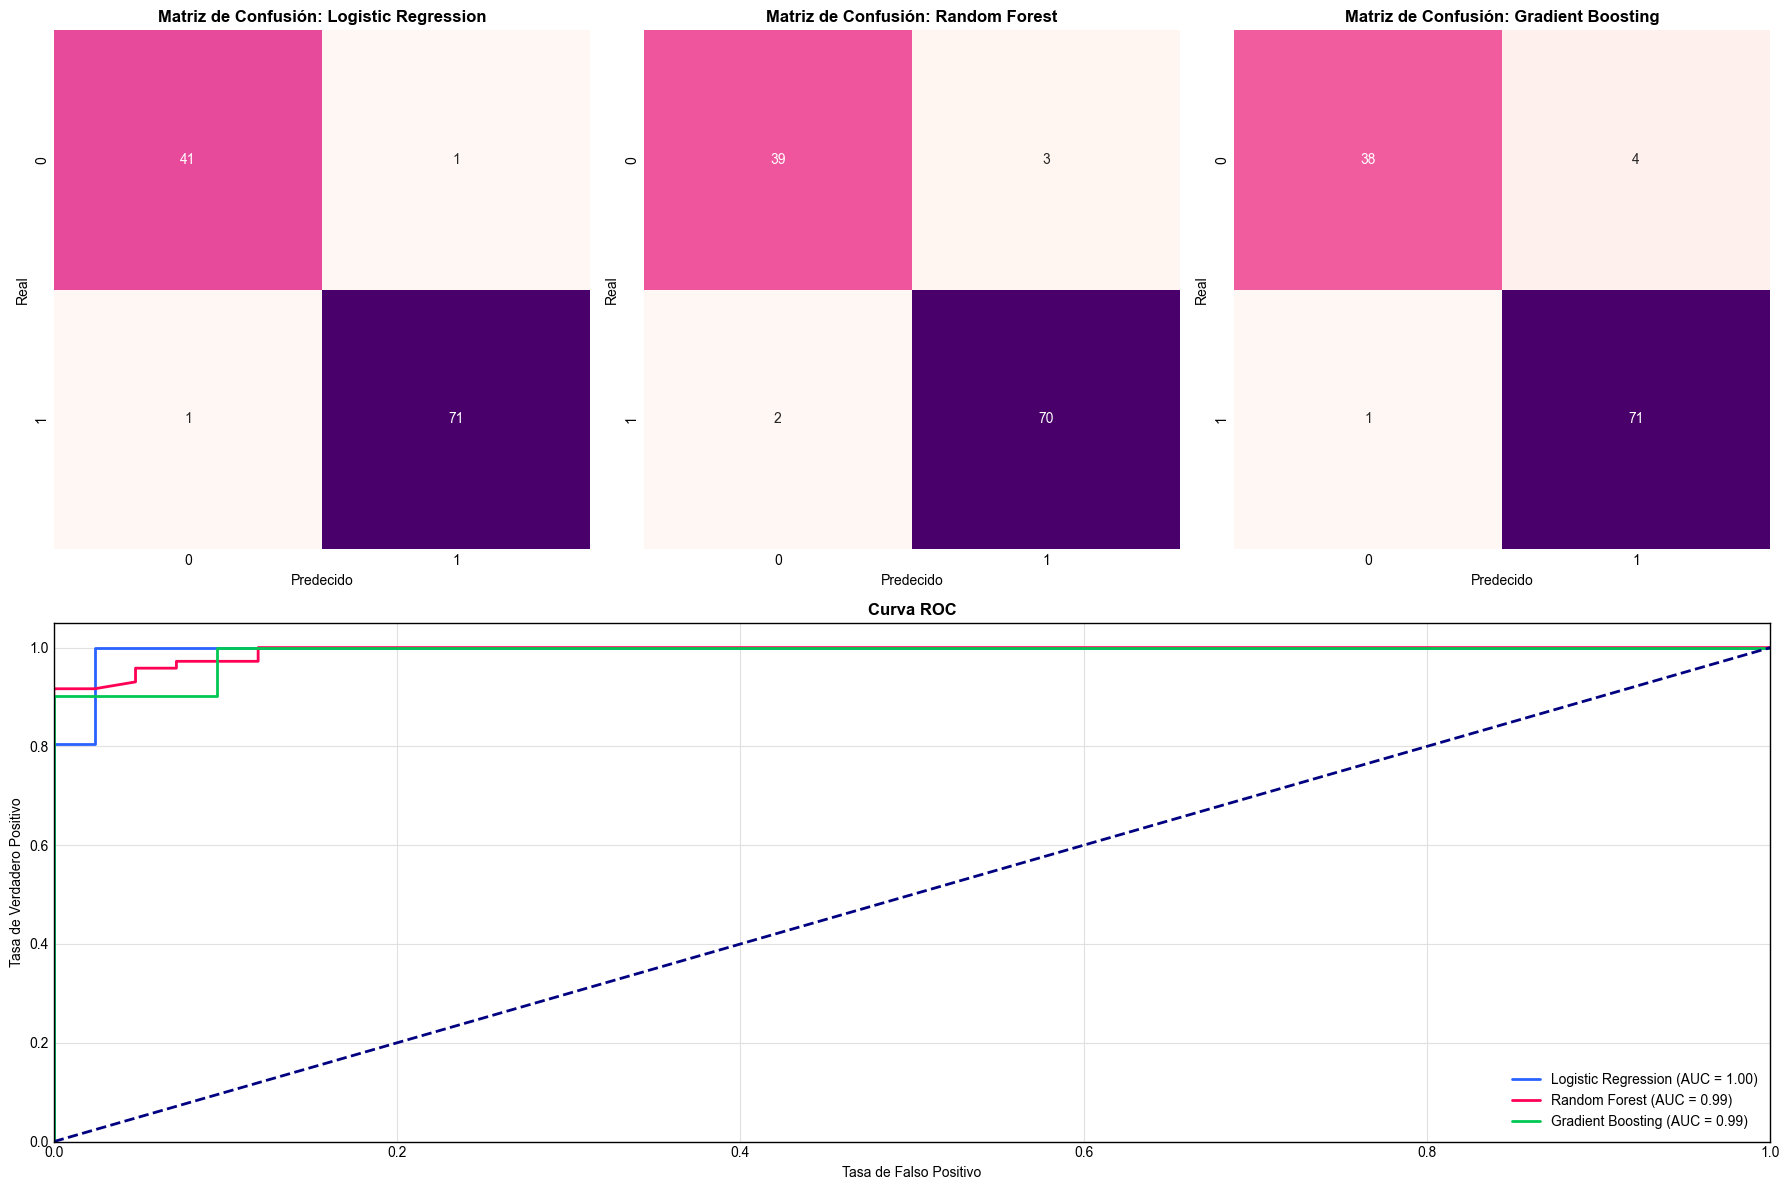

In [19]:
plot_model_comparison(results)

### Diagnóstico de Bias vs Variance (Curvas de Aprendizaje)
Las curvas de aprendizaje nos dicen si añadir más datos ayudaría o si el modelo es demasiado simple/complejo.

**Interpretación:**
*   **High Bias (Underfitting):** Ambas curvas convergen a un error alto.
*   **High Variance (Overfitting):** Gran brecha entre la curva de entrenamiento (error bajo) y validación (error alto).
*   **Buen Ajuste:** Brecha pequeña y ambas curvas convergen a un error bajo.

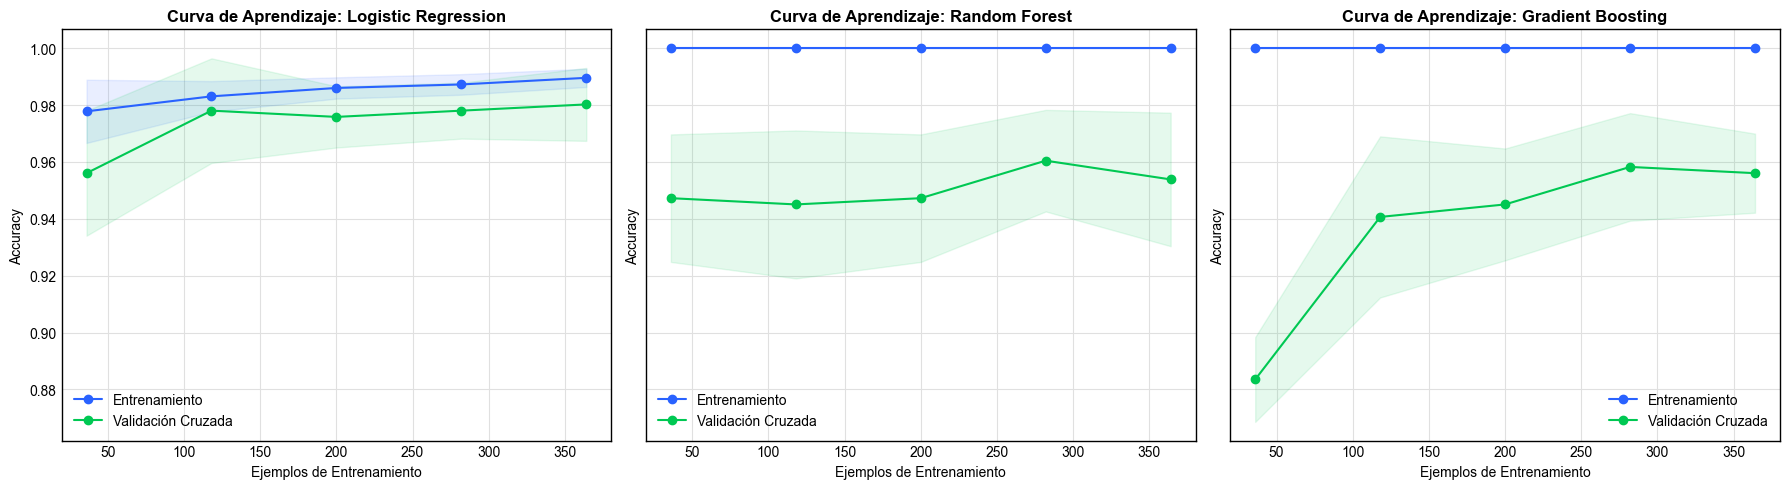

In [20]:
# Usamos pipelines completos para el diagnóstico
from src.processing import create_pipeline

models_pipelines = {name: create_pipeline(model) for name, model in get_models().items()}
plot_learning_curves(models_pipelines, X_train, y_train)

## G. Conclusión Final

Basado en nuestro análisis exhaustivo:

1.  **Rendimiento:** Todos los modelos muestran un rendimiento excelente (>95% Accuracy), lo cual es esperado dado que el pairplot mostró una clara separabilidad lineal en las características principales.
2.  **Diagnóstico:** Las curvas de aprendizaje muestran una brecha estrecha entre entrenamiento y validación, lo que indica que **no sufrimos de un overfitting grave** y que los modelos generalizan bien.
3.  **Selección:** La **Regresión Logística** es probablemente la mejor opción por su simplicidad e interpretabilidad, dado que alcanza un rendimiento casi idéntico a los modelos más complejos.